In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=b257217542667f8b53a06f731e009caed35a17b1bc9d63e4a939d15c7e2eabe4
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils


In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

In [3]:
dataset_path = './dataset'

## Build Dataset

In [4]:
%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal

### Covid xray dataset

In [5]:
samples = 25

In [6]:
covid_dataset_path = '../input/covid-chest-xray'

In [7]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

### Build normal xray dataset

In [8]:
pneumonia_dataset_path ='../input/chest-xray-pneumonia/chest_xray'

In [9]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

## Plot x-rays

Helper function to plot the images in a grid

In [10]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [11]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

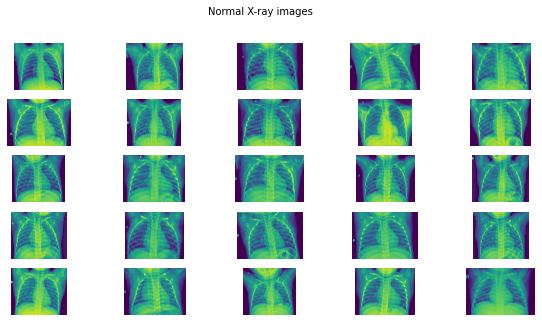

In [12]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

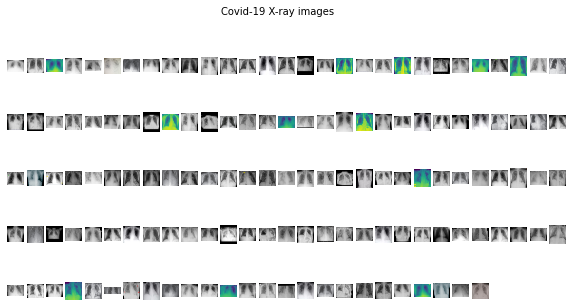

In [13]:
plots_from_files(covid_images, rows=5, maintitle="Covid-19 X-ray images")

## Data preprocessing

In [14]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 30
BS = 8

In [15]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [16]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
 
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

## Model

In [17]:
# load the DenseNet201 network, ensuring the head FC layer sets are left
# off
baseModel = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

74842112/74836368 [==============================] - 1s 0us/step


In [18]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

__________________________________________________________________________________________________
conv5_block18_2_conv (Conv2D)   (None, 7, 7, 32)     36864       conv5_block18_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block18_concat (Concatena (None, 7, 7, 1472)   0           conv5_block17_concat[0][0]       
                                                                 conv5_block18_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block19_0_bn (BatchNormal (None, 7, 7, 1472)   5888        conv5_block18_concat[0][0]       
__________________________________________________________________________________________________
conv5_block19_0_relu (Activatio (None, 7, 7, 1472)   0           conv5_block19_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_bloc

### Training

In [19]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/30
16/16 [==============================] - 7s 434ms/step - loss: 0.5081 - accuracy: 0.8387 - val_loss: 0.0931 - val_accuracy: 0.9706
Epoch 2/30
16/16 [==============================] - 2s 109ms/step - loss: 0.1873 - accuracy: 0.9435 - val_loss: 0.0488 - val_accuracy: 1.0000
Epoch 3/30
16/16 [==============================] - 2s 103ms/step - loss: 0.1209 - accuracy: 0.9677 - val_loss: 0.0363 - val_accuracy: 1.0000
Epoch 4/30
16/16 [==============================] - 2s 105ms/step - loss: 0.0915 - accuracy: 0.9839 - val_loss: 0.0546 - val_accuracy: 1.0000
Epoch 5/30
16/16 [==============================] - 2s 104ms/step - loss: 0.0695 - accuracy: 0.9758 - val_loss: 0.0192 - val_accuracy: 1.0000
Epoch 6/30
16/16 [==============================] - 2s 124ms/step - loss: 0.0669 - accuracy: 0.9919 - val_loss: 0.0174 - val_accuracy: 1.0000
Epoch 7/30
16/16 [==============================] - 2s 104ms/step - loss: 0.0750 - accuracy: 0.991

In [20]:
from IPython.display import FileLink

### Plot trining metrics

/kaggle/working/plot.png

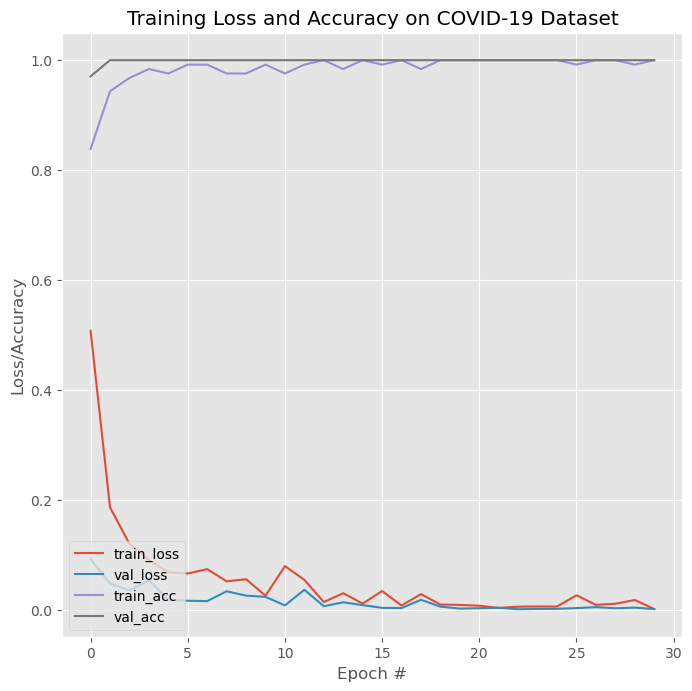

In [21]:



# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(8,8), dpi=100)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

FileLink(r'plot.png')

### Evaluation

In [22]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

report = classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_)

with open('classification_report.txt','w') as f:
    f.write(report)
    
FileLink(r'classification_report.txt')

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        29
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



/kaggle/working/classification_report.txt

#### Confusion matrix

In [23]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))



[[29  0]
 [ 0  5]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    
    plt.figure(figsize=(8,8), dpi=100)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig('Confusion_matrix.png')
    

/kaggle/working/Confusion_matrix.png

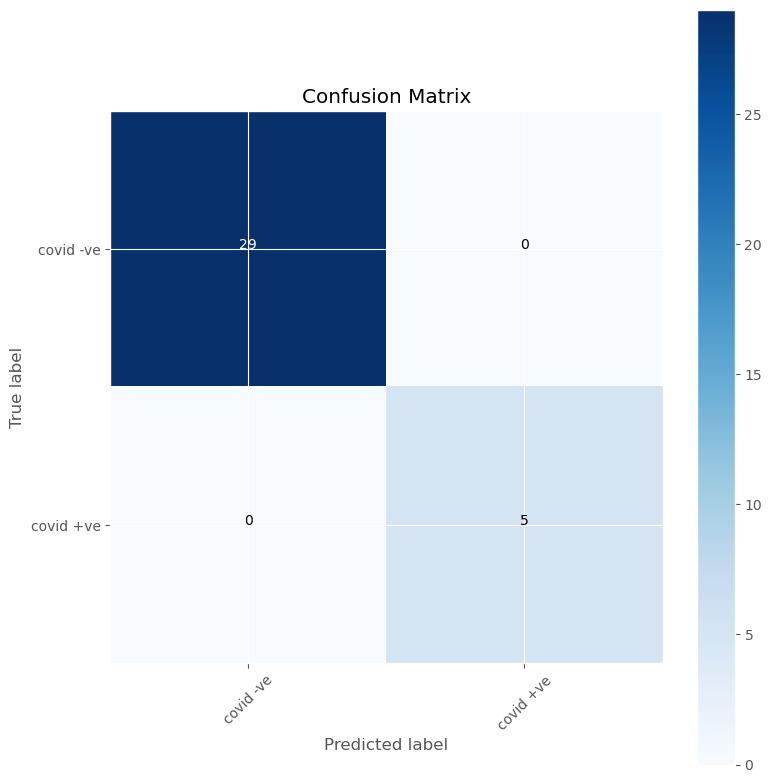

In [25]:
cm_plot_labels = ['covid -ve','covid +ve']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

FileLink(r'Confusion_matrix.png')

Now save the model

In [26]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('DenseNet201_covid_model.h5') 

In [27]:
from IPython.display import FileLink

FileLink(r'DenseNet201_covid_model.h5')

/kaggle/working/Resnet50_covid_model.h5

Test loaded model

In [28]:
from tensorflow.keras.models import load_model
# Recreate the exact same model, including its weights and the optimizer
new_model = load_model('DenseNet201_covid_model.h5')

# Show the model architecture
new_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

conv5_block10_1_bn (BatchNormal (None, 7, 7, 128)    512         conv5_block10_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block10_1_relu (Activatio (None, 7, 7, 128)    0           conv5_block10_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block10_2_conv (Conv2D)   (None, 7, 7, 32)     36864       conv5_block10_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block10_concat (Concatena (None, 7, 7, 1216)   0           conv5_block9_concat[0][0]        
                                                                 conv5_block10_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block11_0_bn (BatchNormal (None, 7, 7, 1216)   4864        conv5_block10_concat[0][0]       
__________

In [29]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = new_model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        29
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



Test on covid image:

[[1.0000000e+00 1.2107955e-13]]
[0]


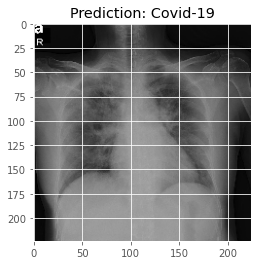

In [30]:
import numpy as np
from tensorflow.keras.preprocessing import image


#test_image = cv2.imread('../input/covid-chest-xray/images/1-s2.0-S1684118220300608-main.pdf-002.jpg')
#test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
#test_image = cv2.resize(test_image, (224, 224))
#test_image = np.expand_dims(test_image, axis = 0)

img_width, img_height = 224, 224
img = image.load_img('../input/covid-chest-xray/images/1-s2.0-S0929664620300449-gr2_lrg-a.jpg', target_size = (img_width, img_height))
x = image.img_to_array(img)
img = np.expand_dims(x, axis = 0)

pred = new_model.predict(img)
print(pred)

#one = new_model.predict('../input/covid-chest-xray/images/1-s2.0-S1684118220300608-main.pdf-002.jpg', batch_size = BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
print(np.argmax(pred, axis=1))

if np.argmax(pred, axis=1)[0] == 1:
    plt.title('Prediction: Non_Covid-19')
else:
    plt.title('Prediction: Covid-19')
    
plt.imshow(x/255.)
plt.savefig('plot_out.png')

Test on normal image:

In [1]:
img_width, img_height = 224, 224
img = image.load_img('../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0003-0001.jpeg', target_size = (img_width, img_height))
x = image.img_to_array(img)
img = np.expand_dims(x, axis = 0)

pred = new_model.predict(img)
print(pred)

#one = new_model.predict('../input/covid-chest-xray/images/1-s2.0-S1684118220300608-main.pdf-002.jpg', batch_size = BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
print(np.argmax(pred, axis=1)[0])
if np.argmax(pred, axis=1)[0] == 1:
    plt.title('Prediction: Non_Covid-19')
else:
    plt.title('Prediction: Covid-19')
plt.imshow(x/255.)

NameError: name 'image' is not defined